## Annex 1. Source code - Application I - Binary classification for soil liquefaction
### I - A.Goh model reproduction
#### Dependencies import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
from scipy.interpolate import interp1d
from sklearn import metrics, preprocessing, linear_model
from sklearn.preprocessing import StandardScaler , MinMaxScaler
from sklearn  import model_selection 
from sklearn.model_selection import train_test_split,learning_curve, cross_val_score,cross_val_predict,cross_validate
from sklearn.preprocessing import minmax_scale
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn  import model_selection 
from sklearn.utils import shuffle
from IPython.display import Image, display
import time
# seed_pi = 3141592
seed_pi= 9
np.random.seed(seed_pi)#sets random seed

#### Import and preview dataset

In [2]:
dataset = pd.read_csv('lichefiere.csv', header=0)
print('Dataset preview:')
display(dataset.head())
print('Dimension =',dataset.shape)

Dataset preview:


,mag,s0,sp0,spt,ag,tau_dinamic,pfine,d50,outcome
0,7.9,186.4,96.1,20.0,0.32,0.36,0,0.46,1
1,7.9,130.5,81.4,10.0,0.32,0.32,5,0.28,1
2,7.9,111.8,71.6,17.0,0.28,0.28,3,0.80,1
3,7.9,93.2,67.7,13.0,0.28,0.25,4,0.60,1
4,7.9,122.6,93.2,10.0,0.20,0.16,10,0.25,1


Dimension = (85, 9)


#### Legend
(1) mag = M - Earthquake's magnitude on Richter scale <br>
(2) s0  = $\sigma_0$  - Total vertical stress (kPa)<br>
(3)	sp0	= $\sigma^{'}_0$- Effective vertical stress (kPa)<br>
(4)	spt	= ${(N_1)}_{60}$ - SPT test , normalized<br>
(5)	ag	= $\frac{a}{g}$- Maximum horizontal acceleration (in terms of g) <br>
(6)	tau_dinamic = $\frac{\tau_{av}}{\sigma^{'}_{0}}$	- Dynamic shear stress at depth z<br>
(7)	pfine=$F(\%$)	- Percent of fine particles<br>
(8)	d50	 =$D_{50}$- Median diameter of particles(mm)<br>
(9) outcome - 1 = Soil liquefied / 0 = Liquefaction did not occur<br>
$ tau\_dinamic=\frac{\tau_{av}}{\sigma^{'}_{0}}=0.1\frac{a}{g}(M-1)\frac{\sigma_0}{\sigma^{'}_{0}}(1-0.015z) $

#### Input dataset visualization

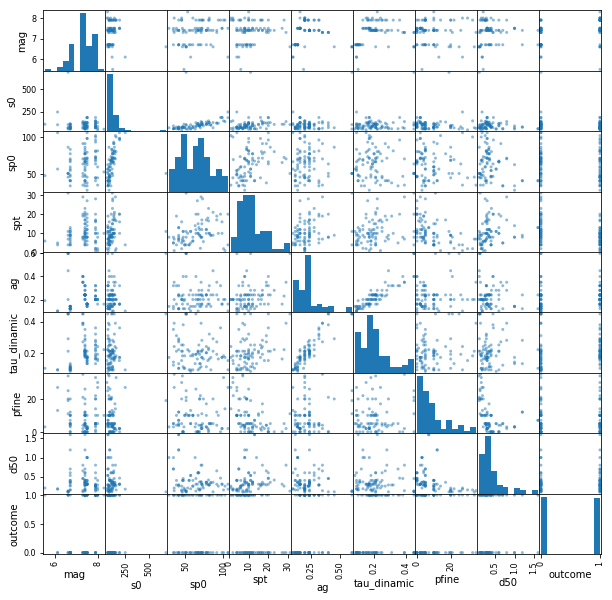

In [3]:
pd.plotting.scatter_matrix(dataset, figsize=(10, 10));

#### Correlation matrix

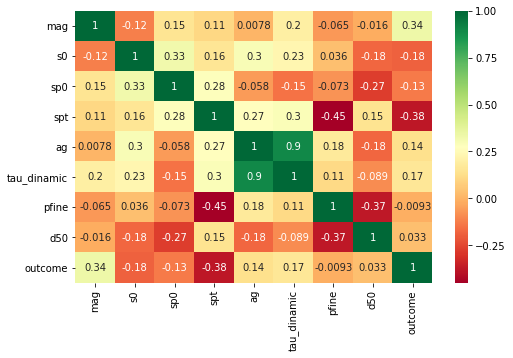

In [4]:
plt.subplots(figsize=(8, 5))
sns.heatmap(dataset.corr(), annot=True, cmap="RdYlGn")
plt.show()

### Splitting the dataset into training and testing
According to A.Goh paper the first 59 input points where used for the neural network training, while the remaining 26 where used for assesing the accuracy of the model. To improve the result values will be scaled in the interval [0, 1] .

In [5]:
# Dataframe to numpy array, scalling of the input features
X = dataset.values[:,0:8]
Y = dataset.values[:,8]
# scaler_x = StandardScaler()
scaler_x = MinMaxScaler()
X_scalled = scaler_x.fit_transform(X)
X_train, X_test, Y_train, Y_test = X_scalled[:59], X_scalled[59:], Y[:59], Y[59:]

### Network topology used in A. Goh paper

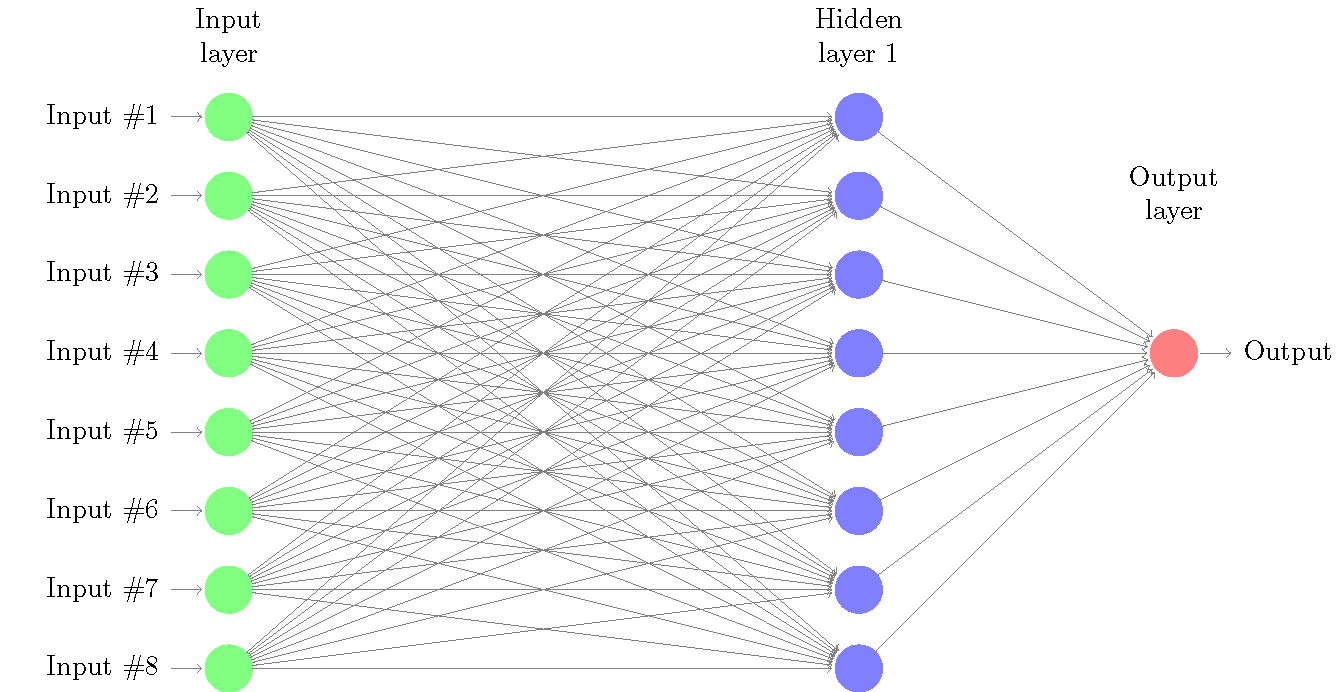

In [6]:
Image(filename="nn_tikz_goh.png", width=700, height=700)

### Building the MLP (multilayer perceptron) with Sklearn
#### The network has a single hidden layer containing eight neurons. To create the model it was used the MLPClassifier class from sklearn library. The number of training epochs, learning rate and momentum were fixed according to the study.

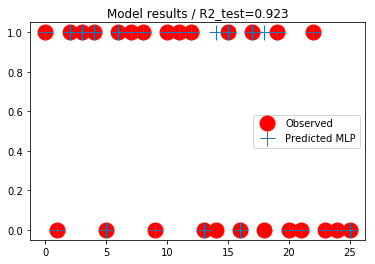

Training time =  4.9 seconds


In [7]:
start_time = time.time()
model_goh=MLPClassifier(hidden_layer_sizes=(8,), max_iter=30000,learning_rate='constant', activation='logistic',
                        learning_rate_init=0.1, momentum=0.075, solver= "sgd", batch_size=59, shuffle=False, tol=1e-5, random_state=seed_pi)
model_goh.fit(X_train, Y_train)
results = model_goh.predict(X_test)
plt.plot(Y_test, "ro", markersize=15,label="Observed")
plt.plot(results, "+", markersize=15, label="Predicted MLP")
plt.legend()
plt.title("Model results / R2_test="+str(round(model_goh.score(X_test,Y_test),3)))
plt.show();
plt.clf()
plt.close('all')
print("Training time =  %0.1f seconds" % (time.time() - start_time))

#### Learning curve

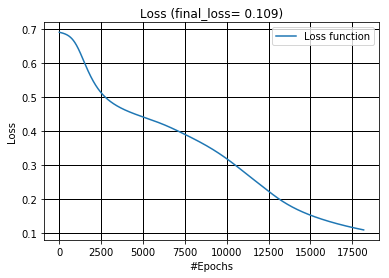

In [8]:
plt.plot(model_goh.loss_curve_, label='Loss function')
plt.title('Loss (final_loss= %0.3f)'%model_goh.loss_)
plt.grid(color='k', linestyle='-', linewidth=1)
plt.xlabel('#Epochs')
plt.ylabel('Loss')
plt.axis('tight')
plt.legend();

### Model accuracy for training, testing and full dataset
#### Coefficient of determination $R^{2}$ formula
Mean of the observed values:  $ \bar {y}={\frac {1}{n}}\sum _{i=1}^{n}y_{i} $

$ SS_{\text{tot}}=\sum _{i}(y_{i}-{\bar {y}})^{2} $ , $ SS_{\text{res}}=\sum _{i}(y_{i}-f_{i})^{2}=\sum _{i}e_{i}^{2}$, where $f_{i}$ are predicted values

$$ R^{2}\equiv 1-{SS_{\rm {res}} \over SS_{\rm {tot}}}=1 - \frac{\sum (e^{2}_{i}) }{\sum ( y_{i} - \bar{y})^{2} } $$

In [9]:
print('Training R2= %0.3f    Loss= %0.3f' % (model_goh.score(X_train, Y_train), model_goh.loss_))
print('Testing  R2= %0.3f' % model_goh.score(X_test, Y_test))
print('Overall  R2= %0.3f' % model_goh.score(X_scalled, Y))

Training R2= 0.983    Loss= 0.109
Testing  R2= 0.923
Overall  R2= 0.965


#### Liquefaction probability

In [10]:
y_prediction_all_prob = model_goh.predict_proba(X_scalled)[:,1]
y_prediction_all = model_goh.predict(X_scalled)
dataset['prediction_probability']= y_prediction_all_prob
dataset['prediction_binary']= y_prediction_all
display(dataset.head())
dataset.to_csv("dataset_p.csv")

,mag,s0,sp0,spt,ag,tau_dinamic,pfine,d50,outcome,prediction_probability,prediction_binary
0,7.9,186.4,96.1,20.0,0.32,0.36,0,0.46,1,0.990604,1.0
1,7.9,130.5,81.4,10.0,0.32,0.32,5,0.28,1,0.999957,1.0
2,7.9,111.8,71.6,17.0,0.28,0.28,3,0.80,1,0.977901,1.0
3,7.9,93.2,67.7,13.0,0.28,0.25,4,0.60,1,0.998787,1.0
4,7.9,122.6,93.2,10.0,0.20,0.16,10,0.25,1,0.749569,1.0


### Particular cases
#### In study was studied the liquefaction of the soil as a function of SPT value and the percent of fine particles. 
The granulomery of the soil (d50) was determined as function of the precent of fine particles (pfine) using the following interpolation points:

,pfine,d50
0,0.0,0.45
1,5.0,0.35
2,10.0,0.25
3,15.0,0.23
4,20.0,0.20
5,25.0,0.10


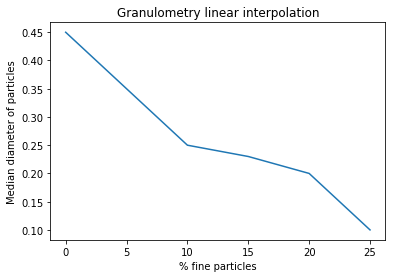

In [11]:
pfine_int = np.array([0,5,10,15,20,25])
d50_int = np.array([0.45,0.35,0.25,0.23,0.2,0.1])
df_d50=pd.DataFrame(np.c_[pfine_int,d50_int],columns=['pfine','d50'])
display(df_d50)
f = interp1d(pfine_int, d50_int, kind='cubic',fill_value ='extrapolate')
plt.title('Granulometry linear interpolation')
plt.xlabel('% fine particles')
plt.ylabel('Median diameter of particles')
plt.plot(pfine_int,d50_int, ls='-');

#### Particular case 1.
##### mag=7.5 / s0=function of(sp0,tau_dinamic,ag,mag,z) / sp0=70 / ag=0.2 / tau_dinamic=0.2 / d50=function of(pfine) / z=20m

In [12]:
mag=7.5
sp0=70
ag=0.1
tau_dinamic=0.1
z=20
s0=sp0*tau_dinamic/0.1/ag/(mag-1)/(1-0.015*z)
df=dataset.replace({'mag': dataset['mag']}, mag)
df=df.replace({'s0': dataset['s0']}, s0)
df=df.replace({'sp0': dataset['sp0']}, sp0)
df=df.replace({'ag': dataset['ag']}, ag)
df=df.replace({'tau_dinamic': dataset['tau_dinamic']}, tau_dinamic)
df['d50']=f(df['pfine'].values)
df=df.drop(['outcome','prediction_probability','prediction_binary'],axis=1)
X2 = df.values[:,0:8]
X_scalled_2 = scaler_x.transform(X2)
df['prediction_binary'] = model_goh.predict(X_scalled_2)
df.head()

,mag,s0,sp0,spt,ag,tau_dinamic,pfine,d50,prediction_binary
0,7.5,153.846154,70.0,20.0,0.1,0.1,0,0.450000,0.0
1,7.5,153.846154,70.0,10.0,0.1,0.1,5,0.350000,0.0
2,7.5,153.846154,70.0,17.0,0.1,0.1,3,0.397131,0.0
3,7.5,153.846154,70.0,13.0,0.1,0.1,4,0.374075,0.0
4,7.5,153.846154,70.0,10.0,0.1,0.1,10,0.250000,0.0


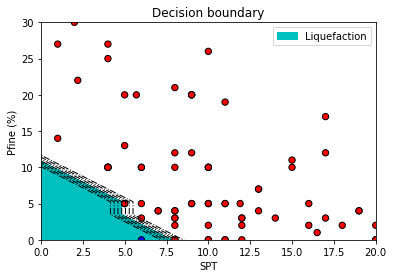

In [13]:
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.patches as mpatches
cmap_light = ListedColormap(['w', 'c'])
patch0 = mpatches.Patch(color='w')
patch1 = mpatches.Patch(color='c', label='Liquefaction')

x_min, x_max = X_scalled_2[:,3].min() - 1, X_scalled_2[:,3].max() + 1
y_min, y_max = X_scalled_2[:,6].min() - 1, X_scalled_2[:,6].max() + 1
h = .05
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, m_max]x[y_min, y_max].
fig, ax = plt.subplots()

X_fill= np.c_[np.full(len(xx.ravel()), X_scalled_2[0,0]), np.full(len(xx.ravel()),X_scalled_2[0,1]),
                            np.full(len(xx.ravel()), X_scalled_2[0,2]),xx.ravel(),np.full(len(xx.ravel()), X_scalled_2[0,4]), 
                            np.full(len(xx.ravel()), X_scalled_2[0,5]),yy.ravel(), f(yy.ravel())]

Z = model_goh.predict(X_fill)

# Put the result into a color plot
Z = Z.reshape(xx.shape)
xx= scaler_x.inverse_transform(X_fill)[:,3].reshape(Z.shape)
yy= scaler_x.inverse_transform(X_fill)[:,6].reshape(Z.shape)
cs=ax.contourf(xx, yy, Z, cmap=cmap_light)
plt.contour(cs, colors='k', linewidths=1,linestyles='dashdot')
# Plot also the training points
categories = np.unique(df['prediction_binary'])
colordict = dict(zip(categories, ['r','b']))  
df["Color"] = df['prediction_binary'].apply(lambda x: colordict[x])
ax.scatter(X2[:, 3], X2[:, 6],c=df["Color"], edgecolor='black', s=40)
ax.set_title('Decision boundary')
ax.set_xlabel('SPT')
ax.set_ylabel('Pfine (%)')
ax.set_xlim(0, 20)
ax.set_ylim(0, 30)
ax.legend(handles=[patch1]);

#### Particular case 2. 
##### mag=7.5 / s0=f(sp0,tau_dinamic,ag,mag,z) / sp0=70 / ag=0.2 / tau_dinamic=0.2 / d50=f(pfine) / z=20m

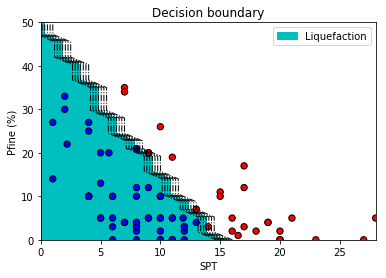

In [14]:
mag=7.5
sp0=70
ag=0.2
tau_dinamic=0.2
z=20
s0=sp0*tau_dinamic/0.1/ag/(mag-1)/(1-0.015*z)
df=dataset.replace({'mag': dataset['mag']}, mag)
df=df.replace({'s0': dataset['s0']}, s0)
df=df.replace({'sp0': dataset['sp0']}, sp0)
df=df.replace({'ag': dataset['ag']}, ag)
df=df.replace({'tau_dinamic': dataset['tau_dinamic']}, tau_dinamic)
df['d50']=f(df['pfine'].values)
df=df.drop(['outcome','prediction_probability','prediction_binary'],axis=1)
X2 = df.values[:,0:8]
X_scalled_2 = scaler_x.transform(X2)
df['prediction_binary'] = model_goh.predict(X_scalled_2)
df.head()
x_min, x_max = X_scalled_2[:,3].min() - 1, X_scalled_2[:,3].max() + 1
y_min, y_max = X_scalled_2[:,6].min() - 1, X_scalled_2[:,6].max() + 1
h = .05
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, m_max]x[y_min, y_max].
fig, ax = plt.subplots()

X_fill= np.c_[np.full(len(xx.ravel()), X_scalled_2[0,0]), np.full(len(xx.ravel()),X_scalled_2[0,1]),
                            np.full(len(xx.ravel()), X_scalled_2[0,2]),xx.ravel(),np.full(len(xx.ravel()), X_scalled_2[0,4]), 
                            np.full(len(xx.ravel()), X_scalled_2[0,5]),yy.ravel(), f(yy.ravel())]

Z = model_goh.predict(X_fill)
# Put the result into a color plot
Z = Z.reshape(xx.shape)
xx_inverse= scaler_x.inverse_transform(X_fill)[:,3].reshape(Z.shape)
yy_inverse= scaler_x.inverse_transform(X_fill)[:,6].reshape(Z.shape)
cs=ax.contourf(xx_inverse, yy_inverse, Z, cmap=cmap_light)
plt.contour(cs, colors='k', linewidths=1,linestyles='dashdot')
# Plot also the training points
categories = np.unique(df['prediction_binary'])
colordict = dict(zip(categories, ['r','b']))  
df["Color"] = df['prediction_binary'].apply(lambda x: colordict[x])
ax.scatter(X2[:, 3], X2[:, 6],c=df["Color"], edgecolor='black', s=40)
ax.set_title('Decision boundary')
ax.set_xlabel('SPT')
ax.set_ylabel('Pfine (%)')
ax.set_xlim(0, 28)
ax.set_ylim(0, 50)
ax.legend(handles=[patch1]);

### II - Sklearn multiple clasification models comparison
#### To asses the best approach fpr this particular problem, where a low number of inputs are available, we can use multiple types of classifiers from the sklearn library (the code was adapted from this source http://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html)
#### The following classifiers will be tested: Logistic regression, Naive Bayes, Support Vector Classification, Random Forest, KNearest Neighbors,  Linear SVM,  RBF SVM,  Gaussian Process, Decision Tree, AdaBoost, QDA
#### This time the training and testing subsets will be chosen at random

In [15]:
X_train, X_test, Y_train, Y_test = train_test_split(X_scalled, Y,
                    test_size=0.3, random_state=seed_pi)

In [16]:
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [17]:
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """Generate a simple plot of the test and training learning curve"""
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
    plt.tight_layout()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    plt.legend(loc="best")
    return plt
kfold = model_selection.StratifiedKFold(n_splits= 10)

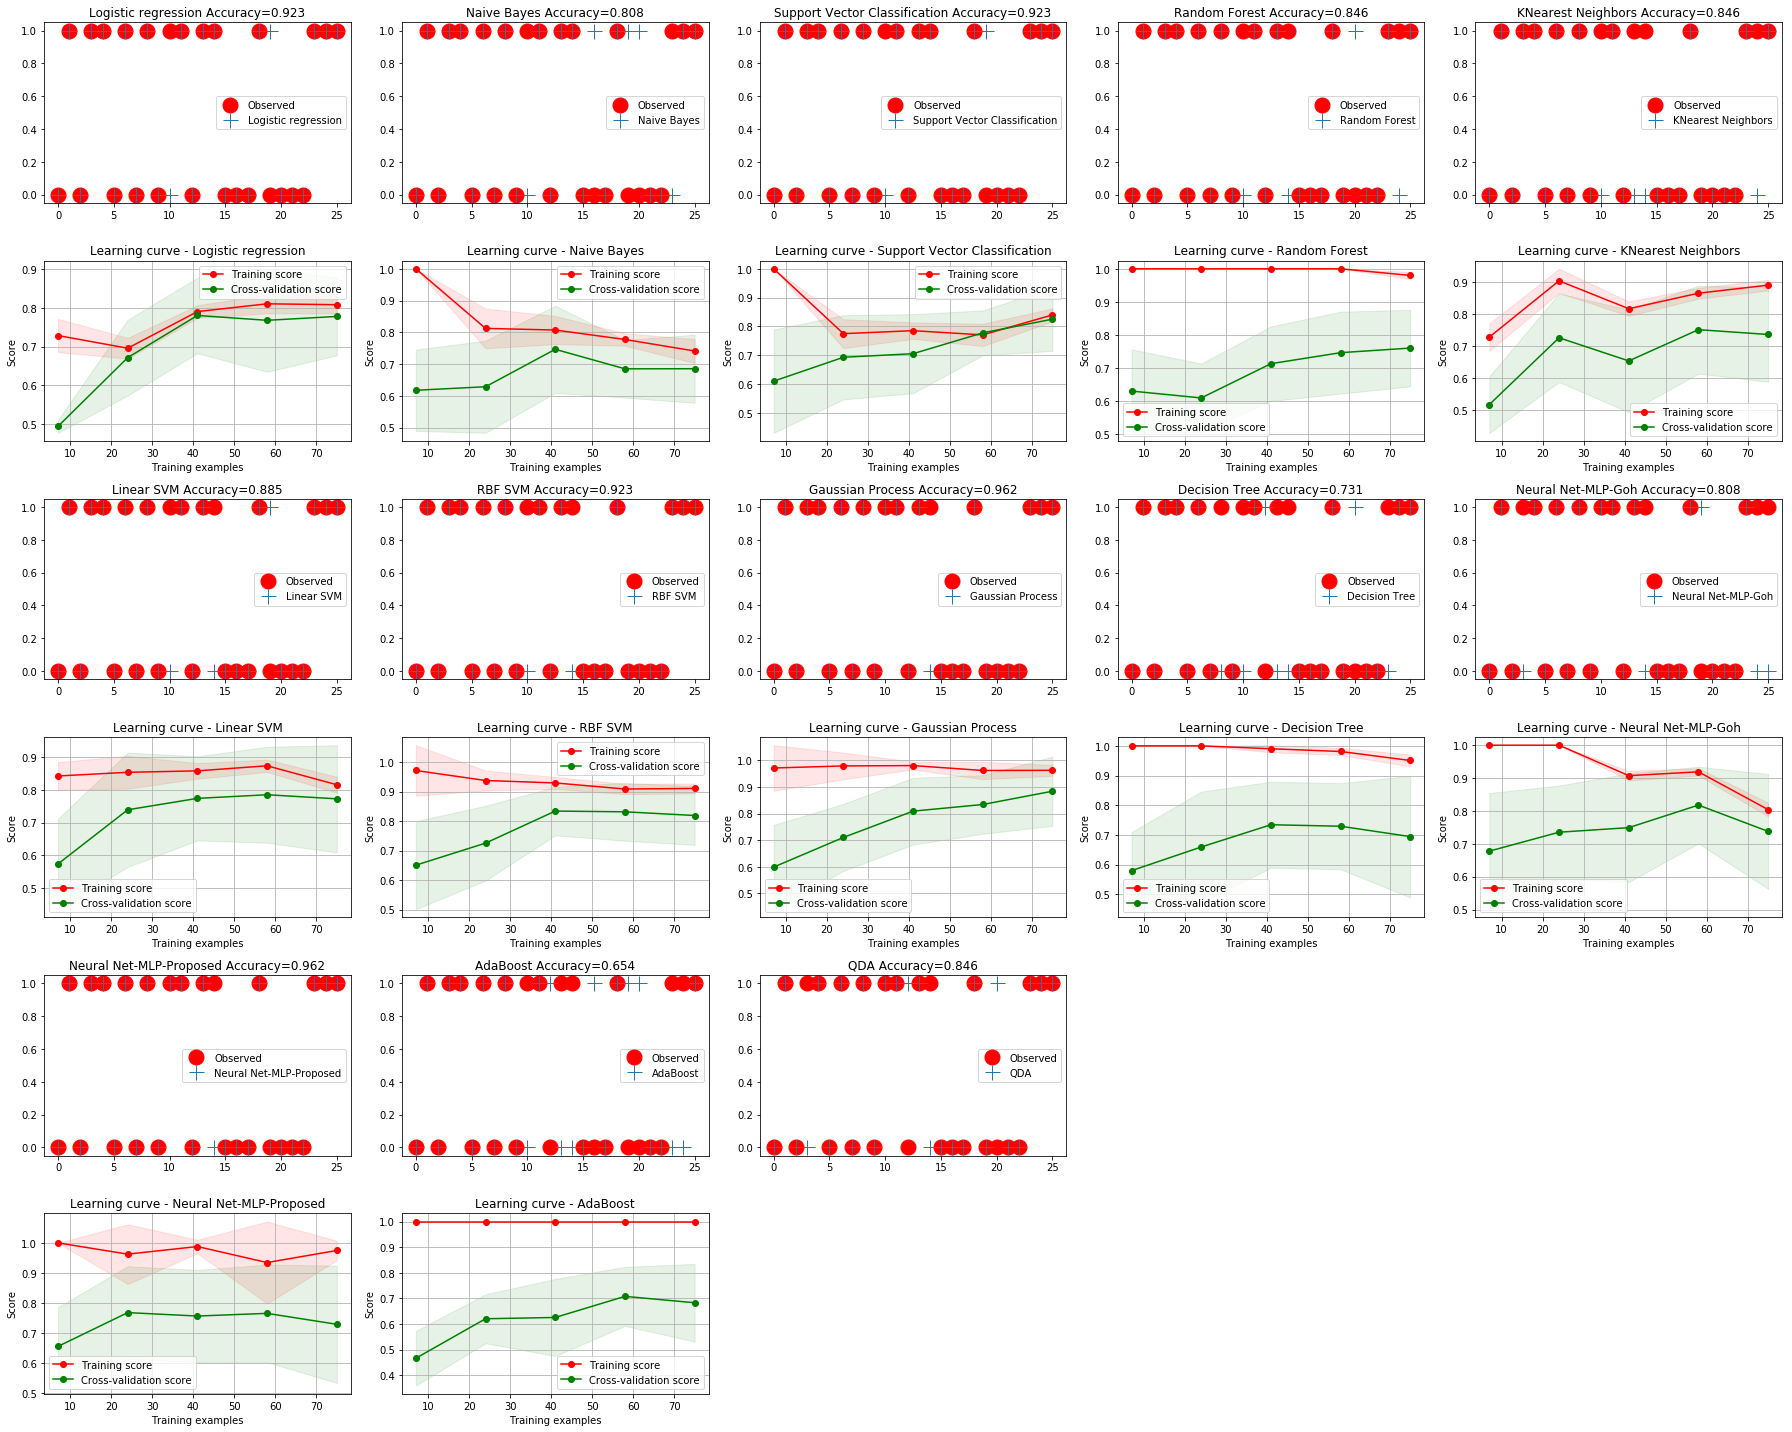

In [18]:
names = ["Logistic regression","Naive Bayes","Support Vector Classification",
         "Random Forest","KNearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
         "Decision Tree", "Neural Net-MLP-Goh","Neural Net-MLP-Proposed", "AdaBoost",
          "QDA"]
classifiers = [
    LogisticRegression(),
    GaussianNB(),
    LinearSVC(C=1.0),
    RandomForestClassifier(max_depth=5, n_estimators=100),
    KNeighborsClassifier(3),
    SVC(kernel="linear"),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    MLPClassifier(hidden_layer_sizes=(8,), max_iter=30000,learning_rate='constant', 
                        learning_rate_init=0.1, momentum=0.075, solver= "sgd", batch_size=59, shuffle=False, tol=1e-10, random_state=seed_pi),
    MLPClassifier(activation= "relu", hidden_layer_sizes= (40, 30, 5), solver= "lbfgs" ,max_iter=10000),
    AdaBoostClassifier(),
    QuadraticDiscriminantAnalysis()]

for clf, name in zip(classifiers, names):
    clf.fit(X_train, Y_train)
r2_train=[]
r2_test=[]
r2_overall=[]
figure = plt.figure(figsize=(25, 20))
i=1
for clf, name in zip(classifiers, names):
    results = clf.predict(X_test)
    r2_train.append(clf.score(X_train,Y_train))
    r2_overall.append(clf.score(X_scalled,Y))
    acci=clf.score(X_test,Y_test)
    r2_test.append(round(acci,4))
    plt.subplot(6, 5, i)
    plt.plot(Y_test, "ro", markersize=15,label='Observed')
    plt.plot(results, "+", markersize=15, label=name)
    plt.legend()
    plt.axis('tight')
    plt.title(name+" Accuracy="+str(round(acci,3)))
    plt.tight_layout()
    if name != "QDA":
        X_s, Y_s = shuffle(X_scalled, Y) # solve class bug
        X_s, Y_s = shuffle(X_s, Y_s)
        X_s, Y_s = shuffle(X_s, Y_s)
        plt.subplot(6, 5, i+5)
        plot_learning_curve(clf,"Learning curve - %s" % name, X_s, Y_s, cv=kfold)
    if i%5==0:
        i+=6
    else:
        i+=1       

In [19]:
df_metod = pd.DataFrame({'Method':names,'R2_train':r2_train,
                         'R2_test':r2_test,'R2_overall':r2_overall})
df_metod.sort_values(by='R2_test', ascending=False)

,Method,R2_train,R2_test,R2_overall
7,Gaussian Process,0.966102,0.9615,0.964706
10,Neural Net-MLP-Proposed,0.949153,0.9615,0.952941
0,Logistic regression,0.762712,0.9231,0.811765
2,Support Vector Classification,0.813559,0.9231,0.847059
6,RBF SVM,0.915254,0.9231,0.917647
5,Linear SVM,0.796610,0.8846,0.823529
3,Random Forest,0.983051,0.8462,0.941176
4,KNearest Neighbors,0.915254,0.8462,0.894118
12,QDA,0.898305,0.8462,0.882353
1,Naive Bayes,0.813559,0.8077,0.811765


### Feature importance for logistic regression model

In [20]:
clf=classifiers[0]
coef = clf.coef_[0].tolist()
abs_sum=sum([abs(k) for k in coef])
coef_scalled = [abs(k)/abs_sum for k in coef]
d = {'Parameter':list(dataset)[0:-3],'coef_logistic_regression':coef,'weight':coef_scalled}
df_coef = pd.DataFrame(data=d)
df_coef.sort_values(by='weight', ascending=False)

,Parameter,coef_logistic_regression,weight
3,spt,-1.767710,0.398971
0,mag,0.776366,0.175225
5,tau_dinamic,0.608667,0.137376
4,ag,0.519651,0.117285
6,pfine,-0.396205,0.089423
7,d50,0.170157,0.038404
2,sp0,-0.157277,0.035497
1,s0,-0.034637,0.007818


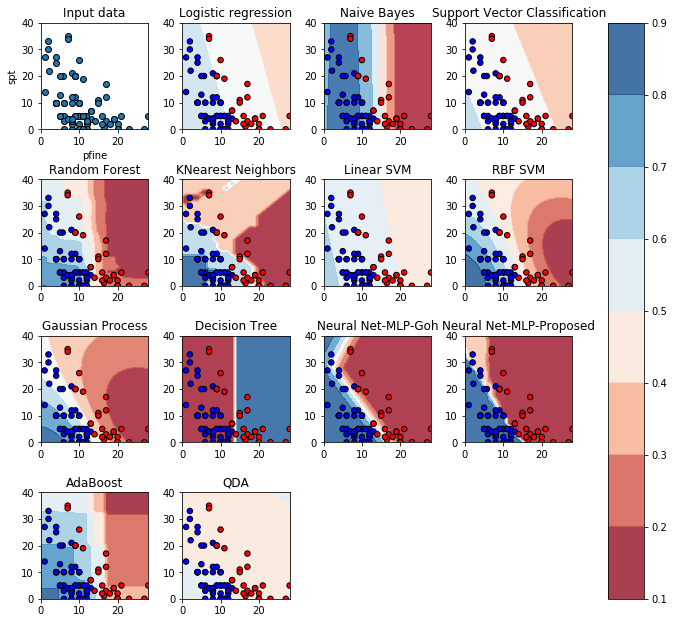

In [21]:
# Code source: Gaël Varoquaux
#              Andreas Müller
# Modified for documentation by Jaques Grobler
# License: BSD 3 clause

h = 0.5  # step size in the mesh
figure = plt.figure(figsize=(10, 10))

i=1
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
ax = plt.subplot(4, 4, i)
ax.set_title("Input data")
ax.scatter(X2[:, 3], X2[:, 6], cmap=cm_bright,
                   edgecolors='k')
ax.set_xlim(0, 28)
ax.set_ylim(0, 40)
ax.set_xlabel('pfine')
ax.set_ylabel('spt')

i+=1
# iterate over classifiers

for name, clf in zip(names, classifiers):
    ax = plt.subplot(4, 4, i)

    if hasattr(clf, "decision_function"):

        Z = (clf.decision_function(X_fill)+100)/200
    else:
        Z = clf.predict_proba(X_fill)[:, 1]
    ZZ=clf.predict(X_fill)
    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    imcf=ax.contourf(xx_inverse, yy_inverse, Z, cmap=cm, alpha=.8)
    # Plot also the training points
    categories = np.unique(ZZ)
    colordict = dict(zip(categories, ['r','b']))  
    df['Color'] = df['prediction_binary'].apply(lambda x: colordict[x])
    ax.scatter(X2[:, 3], X2[:, 6], c=df["Color"], edgecolors='k',s=30)             
    ax.set_xlim(0, 28)
    ax.set_ylim(0, 40)
    ax.set_title(name)
    i += 1
plt.tight_layout()
plt.subplots_adjust(bottom=0.1, right=0.8, top=0.9)
cax = plt.axes([0.85, 0.1, 0.05, 0.8])
plt.colorbar(imcf,cax=cax);